# Mumford Shah Fast Super-Resolution : Exploration

## Google Colab Integration

In [1]:
# !git clone https://github.com/Stage-SuperResolution/MumfordShah.git
# !mv MumfordShah/* .
# !rm -rf MumfordShah
# !pip install git+https://github.com/akhaten/lasp.git@a22e3634d8326742d27d7ea7fa216b59b46a573a

## Import

In [2]:
# Lasp module

import sys
sys.path.append('../../..')

import lasp.io
import lasp.filters.linear
import lasp.noise
import lasp.convert
import lasp.algorithm.experimental
import lasp.thresholding
import lasp.differential
import lasp.utils

# Other

import scipy.signal
import scipy.io.matlab
import numpy
import pandas
import tqdm
import pathlib
import matplotlib.pyplot
import typing
import yaml

# PATH = pathlib.Path('./5-MumfordShahFSR')
# if not(PATH.exists()):
#     PATH.mkdir()

## Mumford-Shah FSR

In [3]:
def mumford_shah_fsr(
    y: numpy.ndarray, 
    h: numpy.ndarray, 
    alpha: float,
    beta0: float,
    beta1: float,
    sigma: float,
    d: int,
    nb_iterations: int,
    tolerance: float,
    gamma: float = 0.,
    error_history: list[float] = None
) -> numpy.ndarray:


    """Mumford Shah
    # TODO: make test
    Solve $$argmin_{x} { (alpha/2) || y - Hx ||^2 + (beta0/2) || nabla y ||^2 + beta1 || nabla y ||_1$$

    Params:
        - y: low resolution
        - h: deblur kernel
        - alpha: hyper parameter of data fidelity
        - beta0: hyper parameter of dirichlet energy
        - beta1: hyper parameter of total variation
        - sigma: split-bregman hyper parameter
        - d: decimation
        - nb_iterations: number of iteration
        - tolerance: tolerance
        - error_history: save errors of each iteration
    
    Returns:
        - high resolution of y
    """

    def block_mm(nr, nc, Nb, x1, order: str) -> numpy.ndarray:

        block_shape = numpy.array([nr, nc])

        x1 = lasp.utils.blockproc_reshape(x1, block_shape, order)
        x1 = numpy.reshape(x1, newshape=(nr*nc, Nb), order=order)
        x1 = numpy.sum(x1, axis=1)
        x = numpy.reshape(x1, newshape=(nr, nc), order=order)

        return x


    # print(alpha, beta0, beta1)

    y_rows, y_cols = y.shape

    Dx_pad = lasp.utils.pad(numpy.array([[1, -1]]), (d*y_rows, d*y_cols))
    Dx = numpy.fft.fft2(Dx_pad)
    Dxt = numpy.conj(Dx)

    Dy_pad = lasp.utils.pad(numpy.transpose(numpy.array([[1, -1]])), (d*y_rows, d*y_cols))
    Dy = numpy.fft.fft2(Dy_pad)
    Dyt = numpy.conj(Dy)

    # Build kernel

    Dx_diag = lasp.utils.fourier_diagonalization(
        kernel = Dx_pad,
        shape_out = (d*y_rows, d*y_cols)
    )
    Dxt_diag = numpy.conj(Dx_diag)

    Dy_diag = lasp.utils.fourier_diagonalization(
        kernel = Dy_pad,
        shape_out = (d*y_rows, d*y_cols) 
    )
    Dyt_diag = numpy.conj(Dy_diag)

    lap_diag = Dxt_diag * Dx_diag + Dyt_diag * Dy_diag  + gamma
   
    h_diag = lasp.utils.fourier_diagonalization(
        kernel = h,
        shape_out = numpy.array([d*y_rows, d*y_cols])
    )

    h_diag_transp = numpy.conj(h_diag)

    h2_diag = numpy.abs(h_diag)**2
 
    STy = numpy.zeros(shape=(d*y_rows, d*y_cols))
    STy[0::d, 0::d] = numpy.copy(y)
    rhs1fft = alpha * h_diag_transp * numpy.fft.fft2(STy)


    # Initialization
    import PIL.Image
    u = numpy.array(
        PIL.Image.Image.resize(
            PIL.Image.fromarray(y),
            (y_rows*d, y_cols*d),
            PIL.Image.Resampling.BICUBIC
        )
    )
    # u = numpy.copy(y) 
    d_x=numpy.zeros_like(u)
    d_y=numpy.zeros_like(u)
    b_x=numpy.zeros_like(u)
    b_y=numpy.zeros_like(u)

    for _ in range(0, nb_iterations):

        rhs2fft = sigma*Dxt*numpy.fft.fft2(d_x-b_x)+sigma*Dyt*numpy.fft.fft2(d_y-b_y)
        rhsfft = rhs1fft + rhs2fft

        u_prev = numpy.copy(u)

        # Inverse
        ##
        # x1 = h_diag*rhsfft / lap_diag
        x1 = h_diag*rhsfft / lap_diag
        fbr = block_mm(y_rows, y_cols, d*d, x1, order='F')
        # invW = block_mm(y.shape[0], y.shape[1], d*d, h2_diag / lap_diag, order='F')
        invW = block_mm(y_rows, y_cols, d*d, h2_diag / lap_diag, order='F')
        # invWBR = fbr / (invW + beta1*d*d)
        invWBR = fbr / ( invW + (beta0+sigma) * (d*d / alpha) )
        fun = lambda block : block*invWBR
        FCBinvWBR = lasp.utils.blockproc(numpy.copy(h_diag_transp), numpy.array([y_rows, y_cols]), fun)
        ## Returns
        u_fft = (rhsfft - FCBinvWBR) / lap_diag
        u_fft /= (beta0 + sigma)
        # u_fft /= beta1
        ##########
        
        # u_fft = rhsfft / uker

        # Compute errors
        u = numpy.real(numpy.fft.ifft2(u_fft))    

        err = numpy.linalg.norm(u-u_prev, 'fro') / numpy.linalg.norm(u, 'fro')
        
        if not(error_history is None):
            error_history.append(err)

        if err < tolerance:
            break
        
        
        u_dx = numpy.real(numpy.fft.ifft2(Dx * u_fft))
        u_dy = numpy.real(numpy.fft.ifft2(Dy * u_fft))


        d_x, d_y = lasp.thresholding.multidimensional_soft(
            d = numpy.array(
                [ 
                    u_dx + b_x, 
                    u_dy + b_y 
                ]
            ),
            epsilon = beta1 / sigma
        )

        b_x += (u_dx - d_x)
        b_y += (u_dy - d_y)

    u_normalized = lasp.utils.normalize(u)

    return u_normalized

## Dataset utils

## Make images/inputs

In [4]:
import dataset
IMAGES_PATH = pathlib.Path('../0-Images')
GENERATION_PATH = pathlib.Path('./images-generated-v2')
if not(GENERATION_PATH.exists()):
    GENERATION_PATH.mkdir()
IMG_GEN_PKL = GENERATION_PATH / 'df_imgs.pkl'

In [5]:
df_imgs = pandas.DataFrame(columns=[ 'original', 'blur', 'decimation', 'noise' ])
noise = lasp.convert.snrdb_to_snr(60)
df_imgs = dataset.add_image(df_imgs, IMAGES_PATH / 'Baboon.bmp', (15, 5), 4, noise)
df_imgs = dataset.add_image(df_imgs, IMAGES_PATH / 'Baboon.bmp', (7, 3), 4, noise)
# df_imgs.attrs['imgs_path'] = IMAGES_PATH
df_imgs.attrs['imgs_gen_path'] = str(GENERATION_PATH)
print(df_imgs.attrs)
df_imgs

{'imgs_gen_path': 'images-generated-v2'}


original     blur decimation   noise
0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0
1  ../0-Images/Baboon.bmp   (7, 3)          4  1000.0

In [6]:
if not(GENERATION_PATH.exists()):
    GENERATION_PATH.mkdir()
dataset.make_images(df_imgs, GENERATION_PATH)

In [7]:
with open(GENERATION_PATH / 'metadatas.yml', 'w') as file:
    yaml.dump(df_imgs.attrs, file)
pandas.to_pickle(df_imgs, IMG_GEN_PKL)

## Make Mumford-Shah parameters

In [8]:
OUTPUT_PATH = pathlib.Path('./outputs_2')
if not(OUTPUT_PATH.exists()):
    OUTPUT_PATH.mkdir()
    
PARAMS_PKL = OUTPUT_PATH / 'df_params.pkl'

In [9]:
df_params = pandas.DataFrame(columns=['df_imgs_index', 'deblur_kernel', 'alpha', 'beta0', 'beta1', 'sigma', 'iterations', 'tol'])

df_params = dataset.add_params(df_params, 0, (21, 3), 1, 1, 1, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 10, 1, 1, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 20, 1, 1, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 40, 1, 1, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 1, 1, 20, 0)

df_params = dataset.add_params(df_params, 0, (21, 3), 60, 3, 1, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 0.5, 1, 1, 20, 0)

df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 0.5, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 2, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 4, 1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1, 20, 0)

df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 0.5, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 2, 20, 0)

df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 0.6, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 0.7, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 0.8, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 0.9, 20, 0)

df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.1, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.2, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.3, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.4, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.5, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.6, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.7, 20, 0)
df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 8, 1.8, 20, 0)


# df_params = dataset.add_params(df_params, 0, (21, 3), 1, 1, 1, 1, 300, 0)


# df_params = dataset.add_params(df_params, 0, (21, 3), 20, 1, 1, 1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 40, 1, 1, 1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 1, 1, 300, 0)

# ##
# df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1e-1, 1, 1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 60, 2, 1, 1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 60, 5e-2, 1, 1, 300, 0)

# ##
# df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 1, 0.5, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 60, 1, 1, 1.5, 300, 0)

# df_params = dataset.add_params(df_params, 0, (21, 3), 80, 1, 1, 0.5, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 80, 1, 1, 1.5, 300, 0)

# # df_params = dataset.add_params(df_params, 0, (21, 3), 80, 1, 1, 0.5, 800, 0)
# # df_params = dataset.add_params(df_params, 0, (21, 3), 80, 1, 1, 1.5, 800, 0)

# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 1, 1, 1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 50, 1, 1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 50, 0.5, 1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 50, 0.1, 1, 300, 0)

# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 50, 0.1, 10, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 50, 0.1, 0.1, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 50, 0.1, 2, 300, 0)
# df_params = dataset.add_params(df_params, 0, (21, 3), 100, 50, 0.1, 3, 300, 0)

begin = 0

df_params.attrs['output_path'] = str(OUTPUT_PATH)
print(df_params.attrs)
df_params

{'output_path': 'outputs_2'}


df_imgs_index deblur_kernel alpha beta0 beta1 sigma iterations tol
0              0       (21, 3)     1     1     1     1         20   0
1              0       (21, 3)    10     1     1     1         20   0
2              0       (21, 3)    20     1     1     1         20   0
3              0       (21, 3)    40     1     1     1         20   0
4              0       (21, 3)    60     1     1     1         20   0
5              0       (21, 3)    60     3     1     1         20   0
6              0       (21, 3)    60   0.5     1     1         20   0
7              0       (21, 3)    60     1   0.5     1         20   0
8              0       (21, 3)    60     1     2     1         20   0
9              0       (21, 3)    60     1     4     1         20   0
10             0       (21, 3)    60     1     8     1         20   0
11             0       (21, 3)    60     1     8   0.5         20   0
12             0       (21, 3)    60     1     8     2         20   0
13             0       (21, 3)    60     1     8   0.6         20   0
14             0       (21, 3)    60     1     8   0.7         20   0
15             0       (21, 3)    60     1     8   0.8         20   0
16             0       (21, 3)    60     1     8   0.9         20   0
17             0       (21, 3)    60     1     8   1.1         20   0
18             0       (21, 3)    60     1     8   1.2         20   0
19             0       (21, 3)    60     1     8   1.3         20   0
20             0       (21, 3)    60     1     8   1.4         20   0
21             0       (21, 3)    60     1     8   1.5         20   0
22             0       (21, 3)    60     1     8   1.6         20   0
23             0       (21, 3)    60     1     8   1.7         20   0
24             0       (21, 3)    60     1     8   1.8         20   0

In [10]:
with open(OUTPUT_PATH / 'metadatas.yml', 'w') as file:
    yaml.dump(df_params.attrs, file)
pandas.to_pickle(df_params, PARAMS_PKL)

## Run Mumford-Shah

In [11]:
def run(
    df_to_process: pandas.DataFrame, 
    index: int
) -> None:

    imgs_gen_path = pathlib.Path(df_to_process.attrs['imgs_gen_path'])
    params = df_to_process.loc[index]
    # print(params.keys())

    df_imgs_index = params['index']

    input_normalized = lasp.io.read(
        imgs_gen_path / str(df_imgs_index) / 'input_normalized.npy'
    )

    
    deblur_kernel = lasp.filters.linear.gaussian_filter(
        params['deblur_kernel'][0],
        params['deblur_kernel'][1]
    )

    alpha = params['alpha']
    beta0 = params['beta0']
    beta1 = params['beta1']
    sigma = params['sigma']
    decim = df_imgs.loc[df_imgs_index]['decimation']
    iterations = params['iterations']
    tol = params['tol']

    error_history = []

    output = mumford_shah_fsr(
        input_normalized, deblur_kernel,
        alpha, beta0, beta1, sigma, decim,
        iterations, tol, gamma=1e-16,
        error_history=error_history
    )

    return output, error_history
    

In [12]:
df_params = pandas.read_pickle(pathlib.Path('./outputs_2/df_params.pkl'))
with open('./outputs_2/metadatas.yml', 'r') as file:
    df_params.attrs = yaml.safe_load(file)
print(df_params.attrs)
df_params

{'output_path': 'outputs_2'}


df_imgs_index deblur_kernel alpha beta0 beta1 sigma iterations tol
0              0       (21, 3)     1     1     1     1         20   0
1              0       (21, 3)    10     1     1     1         20   0
2              0       (21, 3)    20     1     1     1         20   0
3              0       (21, 3)    40     1     1     1         20   0
4              0       (21, 3)    60     1     1     1         20   0
5              0       (21, 3)    60     3     1     1         20   0
6              0       (21, 3)    60   0.5     1     1         20   0
7              0       (21, 3)    60     1   0.5     1         20   0
8              0       (21, 3)    60     1     2     1         20   0
9              0       (21, 3)    60     1     4     1         20   0
10             0       (21, 3)    60     1     8     1         20   0
11             0       (21, 3)    60     1     8   0.5         20   0
12             0       (21, 3)    60     1     8     2         20   0
13             0       (21, 3)    60     1     8   0.6         20   0
14             0       (21, 3)    60     1     8   0.7         20   0
15             0       (21, 3)    60     1     8   0.8         20   0
16             0       (21, 3)    60     1     8   0.9         20   0
17             0       (21, 3)    60     1     8   1.1         20   0
18             0       (21, 3)    60     1     8   1.2         20   0
19             0       (21, 3)    60     1     8   1.3         20   0
20             0       (21, 3)    60     1     8   1.4         20   0
21             0       (21, 3)    60     1     8   1.5         20   0
22             0       (21, 3)    60     1     8   1.6         20   0
23             0       (21, 3)    60     1     8   1.7         20   0
24             0       (21, 3)    60     1     8   1.8         20   0

In [13]:
df_imgs = pandas.read_pickle(pathlib.Path('./images-generated-v2/df_imgs.pkl'))
with open('./images-generated-v2/metadatas.yml', 'r') as file:
    df_imgs.attrs = yaml.safe_load(file)
print(df_imgs.attrs)
df_imgs

{'imgs_gen_path': 'images-generated-v2'}


original     blur decimation   noise
0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0
1  ../0-Images/Baboon.bmp   (7, 3)          4  1000.0

In [14]:
df_to_process = df_imgs.join(df_params.set_index('df_imgs_index'))

# df_to_process = df_params_filtered.set_index('df_imgs_index').join(df_imgs)
df_to_process = df_to_process.dropna(how='any')
df_to_process = df_to_process.reset_index()
df_to_process.attrs.update(df_imgs.attrs)
df_to_process.attrs.update(df_params.attrs)
print(df_to_process.attrs)
df_to_process

{'imgs_gen_path': 'images-generated-v2', 'output_path': 'outputs_2'}


/nix/store/7y5hwh60rvwdwnqkl9g8fqg43q0yd29x-python3.10-pandas-1.4.4/lib/python3.10/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


index                original     blur decimation   noise deblur_kernel  \
0       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
1       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
2       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
3       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
4       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
5       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
6       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
7       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
8       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
9       0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
10      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
11      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
12      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
13      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
14      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
15      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
16      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
17      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
18      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
19      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
20      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
21      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
22      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
23      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   
24      0  ../0-Images/Baboon.bmp  (15, 5)          4  1000.0       (21, 3)   

   alpha beta0 beta1 sigma iterations tol  
0      1     1     1     1         20   0  
1     10     1     1     1         20   0  
2     20     1     1     1         20   0  
3     40     1     1     1         20   0  
4     60     1     1     1         20   0  
5     60     3     1     1         20   0  
6     60   0.5     1     1         20   0  
7     60     1   0.5     1         20   0  
8     60     1     2     1         20   0  
9     60     1     4     1         20   0  
10    60     1     8     1         20   0  
11    60     1     8   0.5         20   0  
12    60     1     8     2         20   0  
13    60     1     8   0.6         20   0  
14    60     1     8   0.7         20   0  
15    60     1     8   0.8         20   0  
16    60     1     8   0.9         20   0  
17    60     1     8   1.1         20   0  
18    60     1     8   1.2         20   0  
19    60     1     8   1.3         20   0  
20    60     1     8   1.4         20   0  
21    60     1     8   1.5         20   0  
22    60     1     8   1.6         20   0  
23    60     1     8   1.7         20   0  
24    60     1     8   1.8         20   0

In [15]:
output_path = pathlib.Path(df_to_process.attrs['output_path'])

for index in tqdm.tqdm(df_to_process[begin:].index):

    CURRENT = output_path / str(index)
    if not(CURRENT.exists()):
        CURRENT.mkdir()

    output, error_history = run(df_to_process, index)

    lasp.io.save(output, CURRENT / 'output.npy')
    lasp.io.save(output, CURRENT / 'output.png')
    lasp.io.save(output, CURRENT / 'error_history.npy')

100%|██████████| 25/25 [01:27<00:00,  3.50s/it]


## Plot

In [16]:
import plot

def plot1x3(df_to_process: pandas.DataFrame, index: int) -> None:
    
    output_path = pathlib.Path(df_to_process.attrs['output_path'])
    
    params = df_to_process.loc[index]


    

    # Get original image
    original = lasp.io.read(params['original'])

    # Get input normalized
    imgs_gen_path = pathlib.Path(df_to_process.attrs['imgs_gen_path'])
    df_imgs_index = params['index']
    input_normalized = lasp.io.read(
        imgs_gen_path / str(df_imgs_index) / 'input_normalized.npy'
    )

    # Get result
    current = output_path / str(index)
    output = lasp.io.read(current / 'output.npy')

    # Plot

    figure = matplotlib.pyplot.figure(
        figsize=(10, 10)
    )
    
    figure.subplots_adjust(top=1.4)
    
    title = plot.title_from(params)
    figure.suptitle('Mumford-Shah \n'+title)
    # figure.tight_layout()
    
    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    ax = figure.subplots(1, 3)
    
    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[0].imshow(original, cmap='gray')


    ax[1].axis('off')
    ax[1].set_title('Img')
    ax[1].imshow(input_normalized, cmap='gray')

    ax[2].axis('off')
    ax[2].set_title('Result')
    ax[2].imshow(output, cmap='gray')

    figure.savefig(current / ('figure1x3.png'))

 80%|████████  | 20/25 [00:05<00:01,  4.06it/s]/run/user/1000/ipykernel_18442/2196261596.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = matplotlib.pyplot.figure(
100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


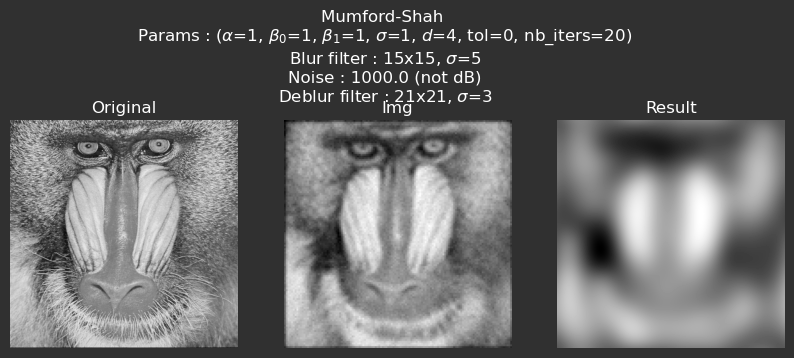

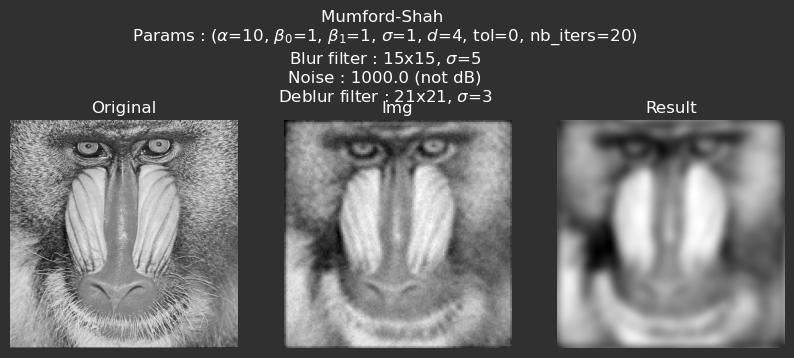

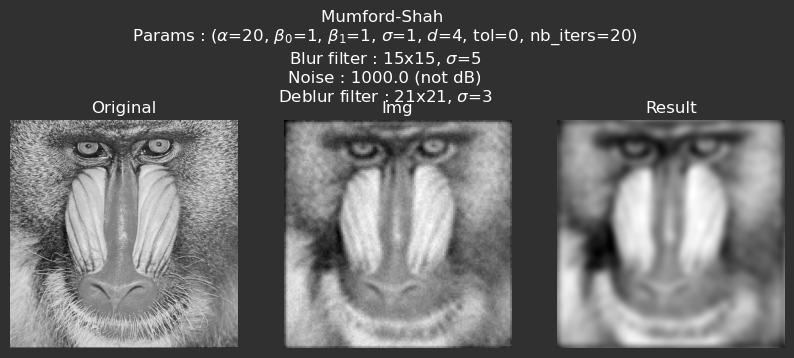

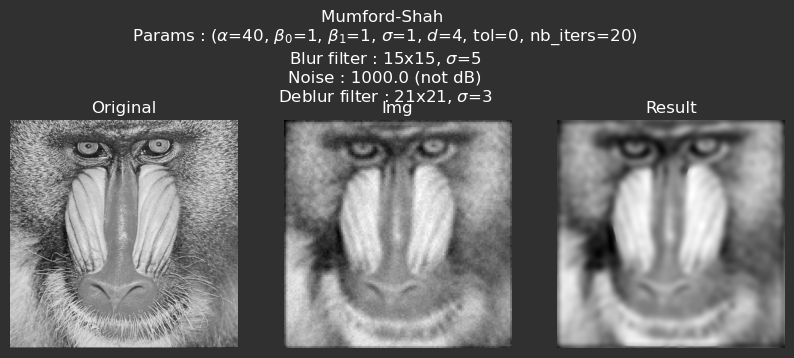

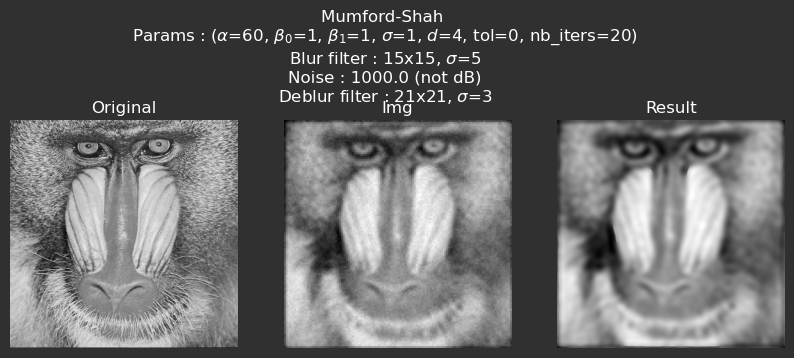

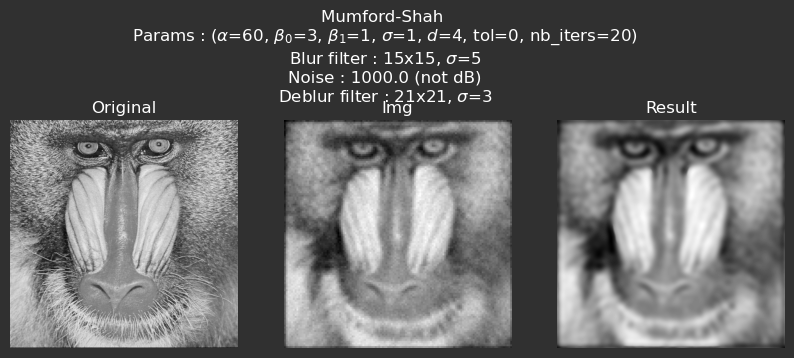

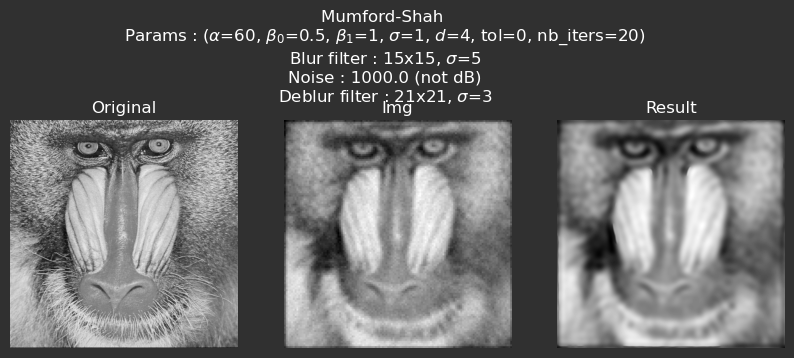

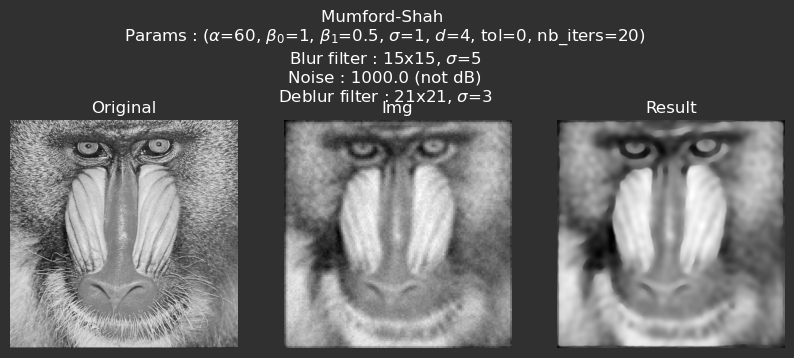

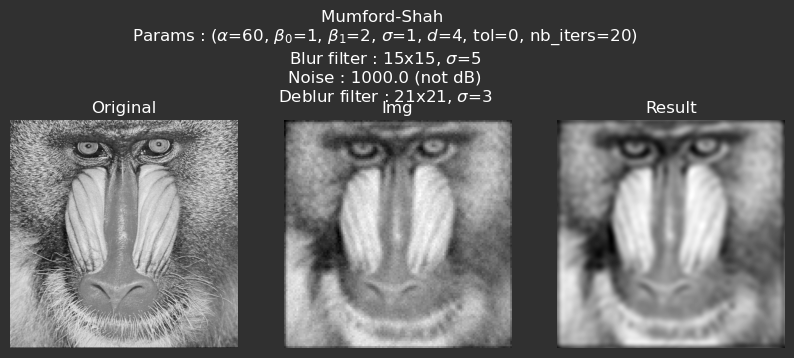

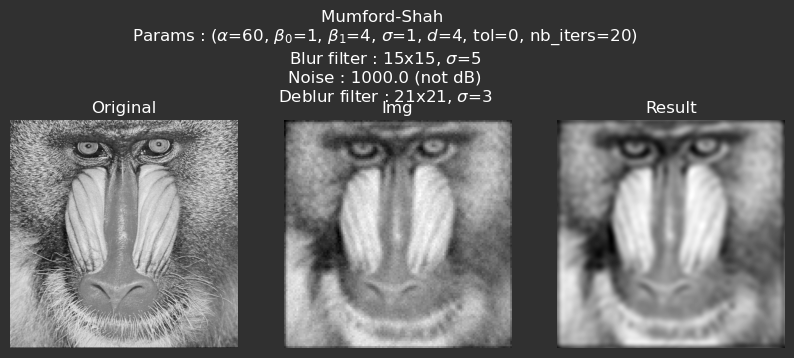

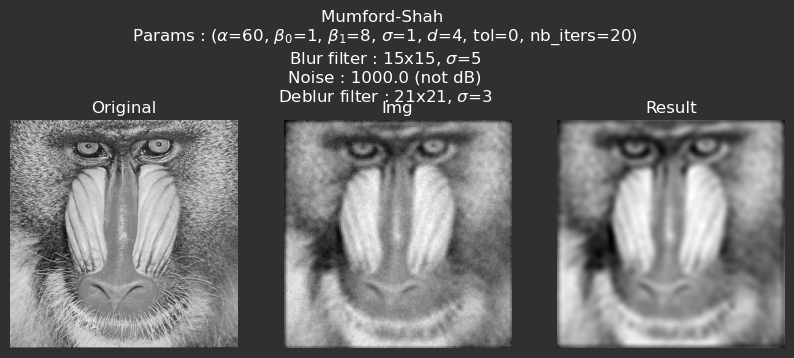

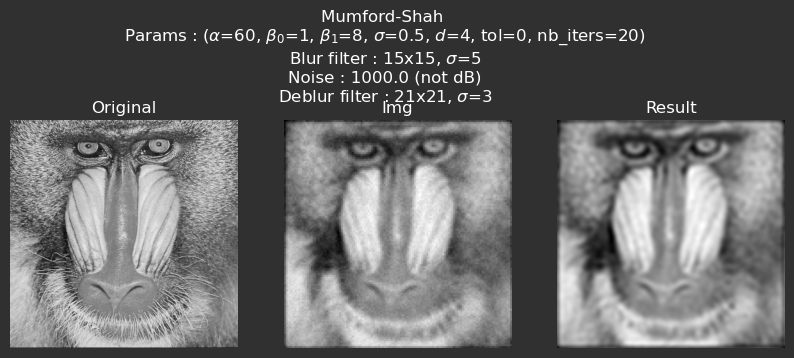

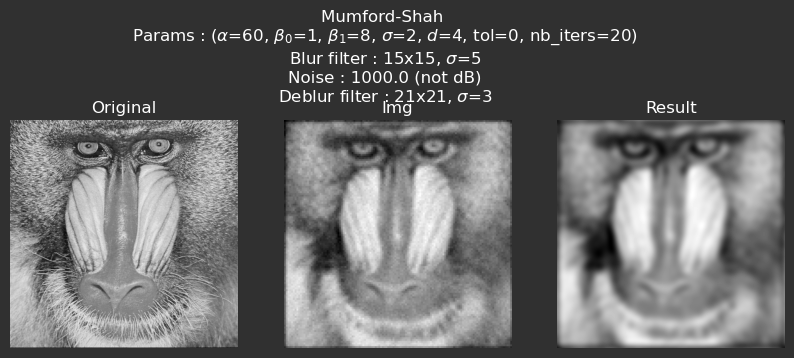

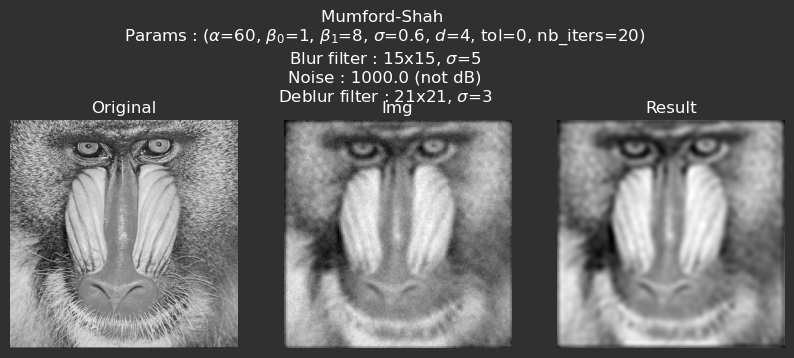

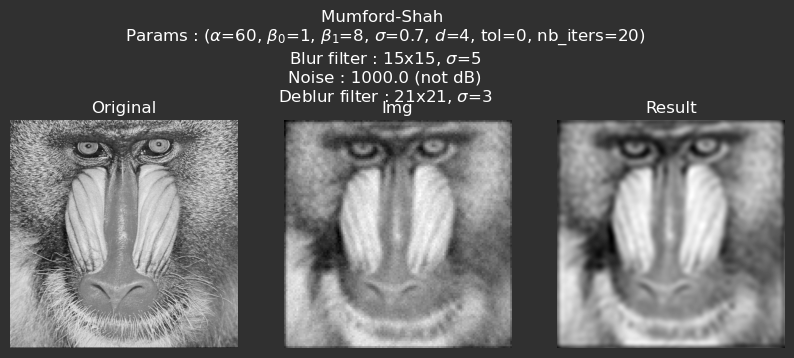

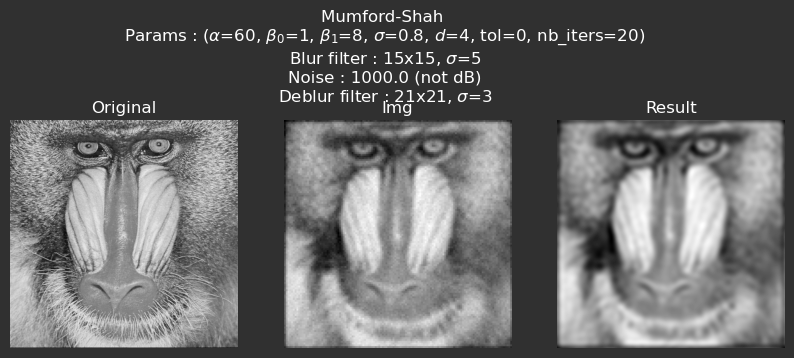

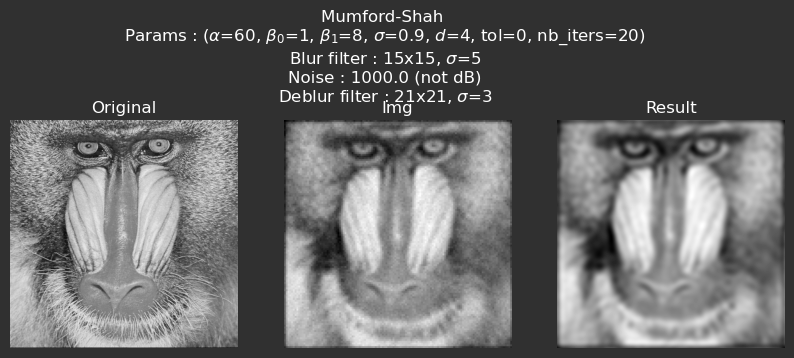

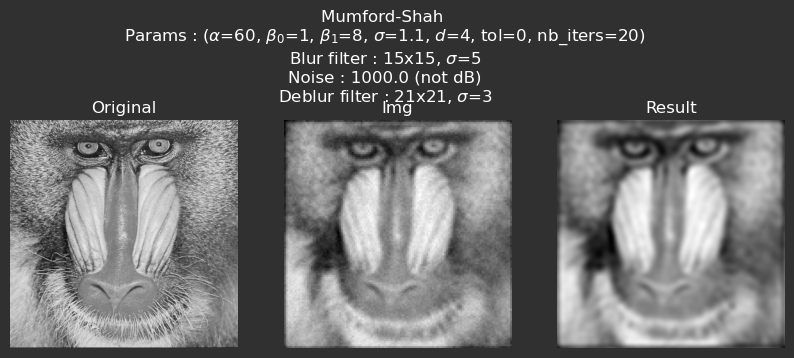

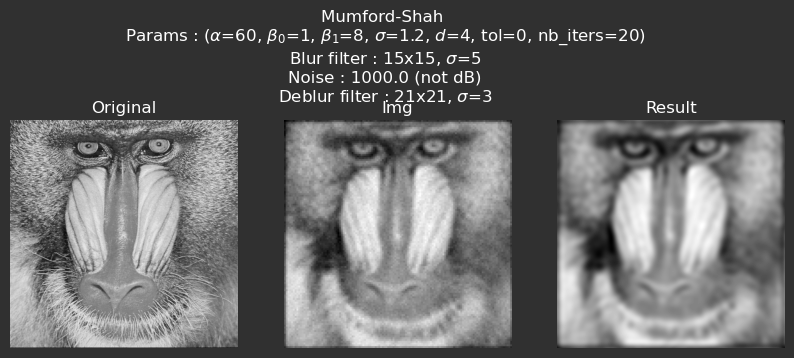

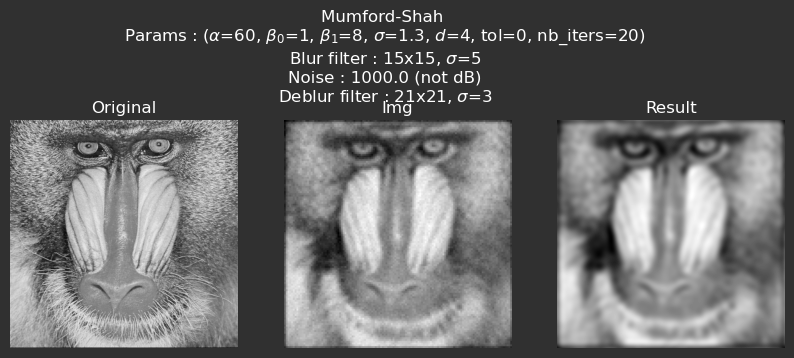

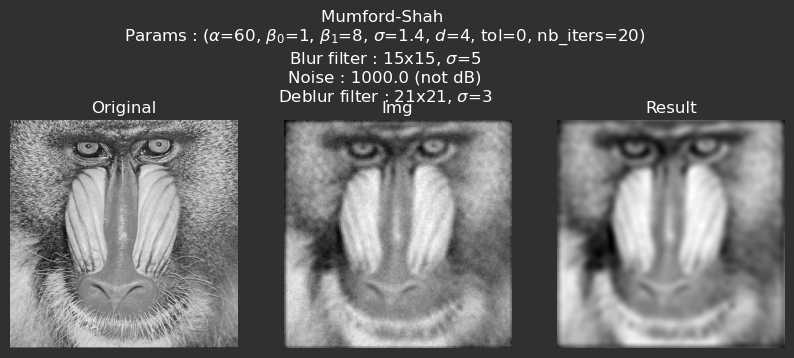

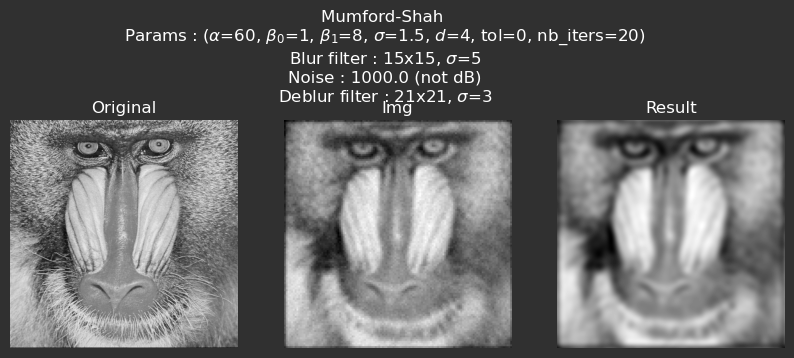

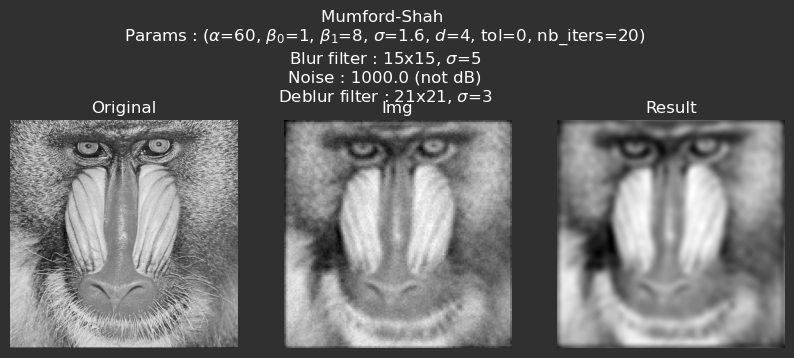

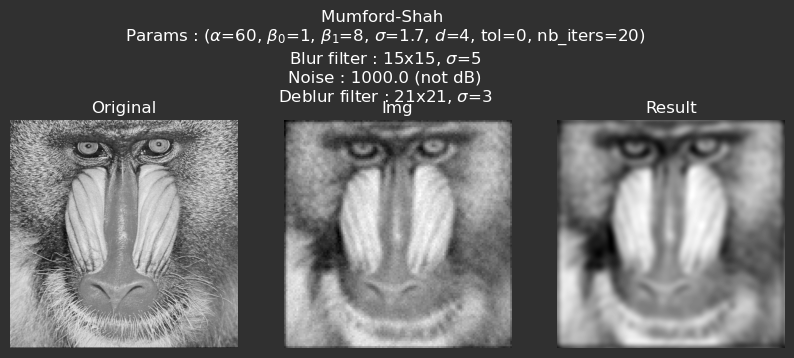

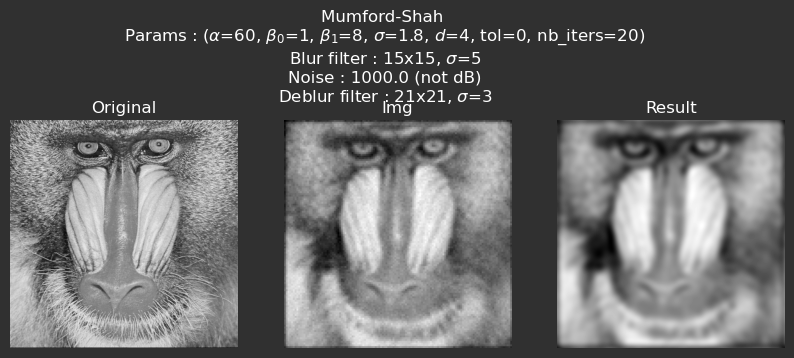

In [17]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = '303030'
matplotlib.rcParams['axes.facecolor'] = '303030'
matplotlib.rcParams['text.color'] = 'FFFFFF'
matplotlib.rcParams['xtick.color'] = 'FFFFFF'
matplotlib.rcParams['ytick.color'] = 'FFFFFF'
matplotlib.rcParams['axes.labelcolor'] = 'FFFFFF'

# df_to_process = df_imgs.join(df_params.set_index('df_imgs_index'))
# df_to_process = df_to_process.dropna(how='any')
# df_to_process = df_to_process.reset_index()
# df_to_process.attrs.update(df_imgs.attrs)
# df_to_process.attrs.update(df_params_filtered.attrs)

for index in tqdm.tqdm(df_to_process.index):
    plot1x3(df_to_process, index)

Hyper-parametres:
- alpha doit augmenter
- beta0 doit augmenter
- beta1 doit diminuer
- sigma doit diminuer

## Segmentation with K-Means Thresholding

In [ ]:
import sklearn.cluster
import numpy


def thresholding_kmeans(img: numpy.ndarray, k: int) -> numpy.ndarray:

    _, idx, _ = sklearn.cluster.k_means(img, k)

    cluster_mean = numpy.zeros(shape=k)

    for i in range(0, k):
        cluster_mean[i] = numpy.mean(img[idx==i])

    cluster_mean_sorted = numpy.sort(cluster_mean)

    thresholds = numpy.zeros(shape=k-1)

    for i in range(0, k-1):
        thresholds[i] = numpy.mean(cluster_mean_sorted[i:i+1])

    return thresholds

In [ ]:
import numpy
import numpy.random

img_rand = numpy.random.randint(0, 255, (60, 60))
thresholds = thresholding_kmeans(img_rand, 4)
thresholds